In [46]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
import pickle
import pandas as pd
import torch
from torch.utils.data import DataLoader

<h3>Convert Images into their Feature Map</h3>

In [47]:
def create_feature_map(train_dataset, transform = transforms.Compose([transforms.ToTensor()]), model = None, method = 0):
    feature_maps = []

    if method == 2:
        transformed_images = [transform(curr_image) for curr_image in train_dataset]
        print("Counting to:", len(transformed_images))
        for i in range(len(transformed_images)):
            print(i, end=" ")
            if i%40==0: print()
            img_emb = model.encode(transformed_images[i])
            feature_maps.append(img_emb)
    else:
        transform_special = transforms.Compose([
            transforms.ToTensor(),
        ])
        transformed_images = [transform_special(transform(curr_image)) for curr_image in train_dataset]

        # Create a DataLoader with your images and transform
        batch_size = 32  # Adjust batch size as neeaded
        data_loader = DataLoader(
            dataset=transformed_images,
            batch_size=batch_size,
            shuffle=False
        )

        # Assuming you have a GPU available, move the model to GPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        print("Counting to:", len(data_loader))
        x = 0 
        all_conv = []
        with torch.no_grad():
            for batch in data_loader:
                if x%10==0: print()
                print(x, end=" ")
                # Move the batch to the appropriate device
                batch = batch.to(device)

                # Forward pass to get predictions
                all_conv.append(model(batch))
                x+=1

        for group in all_conv:
                for curr in group:
                    feature_maps.append(curr.detach().numpy())
    
    print()
    return feature_maps

<h3>Dimensionality Reduction</h3>

In [48]:
def reduce_dimensionality(feature_maps, method = 'pca', desired_variance_threshold = 0.90, verbose=False, epoch_count=None, n_componentor=None, encoding_dim = 256, dimension_limiter=None):
    method = method.lower()
    if method in ['pca', 'princial_component', 'princial_component_analysis']:
        # Convert the list of lists to a NumPy array
        data_array = np.array(feature_maps)

        # Standardize the data (optional but often recommended)
        scaler = StandardScaler()
        data_std = scaler.fit_transform(data_array)

        if n_componentor is None:
            # Apply PCA
            pca = PCA()
            data_pca = pca.fit_transform(data_std)

            # Find the number of components that meet the threshold
            cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
            n_components = np.argmax(cumulative_variance >= desired_variance_threshold) + 1
            if dimension_limiter: n_components=min(n_components, dimension_limiter)

            # Apply PCA with the selected number of components
            pca = PCA(n_components=n_components)
            data_pca = pca.fit_transform(data_std)

            if verbose:
                # Plot the explained variance ratio
                plt.figure(figsize=(6, 4))
                plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.75, align='center', label='Individual explained variance')
                plt.step(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance[:len(pca.explained_variance_ratio_)], where='mid', label='Cumulative explained variance')
                plt.xlabel('Principal Components')
                plt.ylabel('Explained Variance Ratio')
                plt.title('Explained Variance Ratio for Each Principal Component')
                plt.legend()
                plt.show()

                # Print the selected number of components
                print("Selected Number of Components:", n_components)
            return data_pca, ['n_components', n_components]
        else:
            pca = PCA(n_components=n_componentor)
            data_pca = pca.fit_transform(data_std)
            return data_pca, ['n_components', n_componentor]
    elif method in ['autoencoder', 'auto_encoder', 'autoencoding', 'auto']:
        if verbose:
            verbose = 1
        else:
            verbose = 0
        X_train, X_test = train_test_split(feature_maps, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.fit_transform(X_test)

        input_dim = len(feature_maps[0])
        encoding_dim = encoding_dim

        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation='relu')(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)

        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        if epoch_count:
            autoencoder.fit(X_train_scaled, X_train_scaled, epochs= epoch_count, batch_size=15, shuffle=True, validation_data=(X_test_scaled, X_test_scaled), verbose=verbose)
        else:
            autoencoder.fit(X_train_scaled, X_train_scaled, epochs= 25, batch_size=15, shuffle=True, validation_data=(X_test_scaled, X_test_scaled), verbose=verbose)    
        encoder = Model(input_layer, encoded)
        X_train_encoded = encoder.predict(X_train_scaled, verbose=verbose)

        print("Variance of Encoded Data:", (np.sum(np.var(X_train_encoded, axis=0))/ np.sum(np.var(X_train_scaled, axis=0))) * 100, "%")

        input_scaled = scaler.fit_transform(feature_maps)
        return encoder.predict(input_scaled, verbose=verbose), ['encoder', encoder, 'scaler', scaler]
    elif method in ['none', 'no_reduction']:
        print("Total Number of Dimensions:", len(feature_maps[0]))
        return feature_maps, []
    else:
        print("No such dimension reduction method:",method)
        return -1

<h3>Classification of Feature Maps</h3>

In [49]:
def classifier(train_data, test_data, train_labels, test_labels, classify_method:str = 'linear_probe'):
    classify_method = classify_method.lower()
    if classify_method in ['linear_probe', 'logistic_regression', 'logistic', 'lr']:
        from sklearn.linear_model import LogisticRegression
        classifier_model = LogisticRegression(max_iter=1000, solver='lbfgs')
    elif classify_method in ['svm', 'support_vector_machine', 'support']:
        from sklearn.svm import SVC
        classifier_model = SVC()
    elif classify_method in ['random_forest', 'forest', 'rf']:
        from sklearn.ensemble import RandomForestClassifier
        classifier_model = RandomForestClassifier()
    elif classify_method in ['gradient_boosting', 'gb', 'grad']:
        from sklearn.ensemble import GradientBoostingClassifier
        classifier_model = GradientBoostingClassifier()
    elif classify_method in ['naive_bayes', 'bayes', 'nb', 'naive'] :
        from sklearn.naive_bayes import GaussianNB
        classifier_model = GaussianNB()
    elif classify_method in ['decision_tree', 'tree', 'dt'] :
        from sklearn.tree import DecisionTreeClassifier
        classifier_model = DecisionTreeClassifier()
    elif classify_method in ['knn', 'knn1', 'neighbour', 'nearest_neighbour', 'k_nearest_neighbour', 'k_nearest_neighbour_1', 'k_nearest_neighbours', 'k_nearest_neighbours_1'] :
        from sklearn.neighbors import KNeighborsClassifier
        classifier_model = KNeighborsClassifier(n_neighbors=1)
    elif classify_method in ['knn3', '3_neighbours', '3_nearest_neighbour', 'k_nearest_neighbour_3', 'k_nearest_neighbours_3'] :
        from sklearn.neighbors import KNeighborsClassifier
        classifier_model = KNeighborsClassifier(n_neighbors=3)
    elif classify_method in ['knn5', '5_neighbour', '5_nearest_neighbour', 'k_nearest_neighbour_5', 'k_nearest_neighbours_5'] :
        from sklearn.neighbors import KNeighborsClassifier
        classifier_model = KNeighborsClassifier(n_neighbors=5)
    elif classify_method in ['bagging_classifier', 'bagging', 'bc', 'ensemble_method'] :
        from sklearn.ensemble import BaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        base_classifier = DecisionTreeClassifier()
        classifier_model = BaggingClassifier(base_classifier, n_estimators=50)
    elif classify_method in ['eigenproclassifier', 'eigen_pro_classifier', 'epc', 'ep', 'eigen_pro'] :
        from sklearn_extra.kernel_methods import EigenProClassifier
        classifier_model = EigenProClassifier()
    elif classify_method in ['quadratic_discriminant_analysis', 'quadratic_discriminant', 'qda'] :
        from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
        classifier_model = QuadraticDiscriminantAnalysis()
    elif classify_method in ['linear_discriminant_analysis', 'linear_discriminant', 'lda'] :
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        classifier_model = LinearDiscriminantAnalysis()
    else:
        print("No such method for classication:", classify_method)
        return -1
    
    classifier_model.fit(train_data, train_labels)

    # Make predictions on the training and testing dataset
    training_pred = classifier_model.predict(train_data)
    testing_pred = classifier_model.predict(test_data)
    
    classification_analytics = {}
    classification_analytics['train_accuracy'] = accuracy_score(train_labels, training_pred)
    classification_analytics['test_accuracy'] = accuracy_score(test_labels, testing_pred)

    classification_analytics['train_classification_report'] = classification_report(train_labels, training_pred)
    classification_analytics['test_classification_report'] = classification_report(test_labels, testing_pred)
    return classification_analytics

In [50]:
def get_analytics(train_data, test_data, train_labels, test_labels, classification_methods = [], verbose = False, dim_red_method = "no_reduction"):
    if len(classification_methods) == 0:
        print('No classification method given')
    all_analytics = {}

    for method in classification_methods:
        if verbose: print("Current Method:", method)
        classification_analytics = classifier(train_data, test_data, train_labels, test_labels, classify_method=method)
        all_analytics[method+'_with_'+dim_red_method] = classification_analytics
    return all_analytics

In [51]:
def runner(feature_maps_train, feature_labels_train, feature_maps_test, feature_labels_test, classification_methods = ['linear_probe'], dim_red_methods = ['no_reduction'], verbose=False, encoding_dim=256, desired_variance_threshold=0.9, dimension_limiter=None, epoch_count=None):
    overall_accuracy_table = None
    overall_statistics = None
    for red_method in dim_red_methods:
        if verbose: print("Dimension Reduction Technique:", red_method)
        # Reduce the Dimensions
        red_feature_maps_train, extra = reduce_dimensionality(feature_maps_train, method=red_method, desired_variance_threshold=desired_variance_threshold, verbose=verbose, encoding_dim=encoding_dim, dimension_limiter=dimension_limiter, epoch_count=epoch_count)
        
        if len(extra) == 0:
            red_feature_maps_test, extra = reduce_dimensionality(feature_maps_test, method=red_method, verbose=verbose)
        elif extra[0] == 'n_components': 
            red_feature_maps_test, extra = reduce_dimensionality(feature_maps_test, method=red_method, verbose=verbose, n_componentor=extra[1])
        elif extra[0] == 'encoder': 
            input_scaled = extra[3].fit_transform(feature_maps_test)
            red_feature_maps_test = extra[1].predict(input_scaled, verbose=verbose)

        # Get accuracy for different methods
        training_accuracy = get_analytics(red_feature_maps_train, red_feature_maps_test, feature_labels_train, feature_labels_test, classification_methods, verbose=verbose, dim_red_method=red_method)

        accuracy_table = pd.DataFrame(training_accuracy).T
        accuracy_table = accuracy_table.loc[:,['train_accuracy', 'test_accuracy']]
        if overall_accuracy_table is None:
            overall_accuracy_table = [accuracy_table]
            overall_statistics = [training_accuracy]
        else:
            overall_accuracy_table.append(accuracy_table)
            overall_statistics.append(training_accuracy)

    return overall_accuracy_table, overall_statistics

<h3>Create plots here (Optional)</h3>

In [52]:
def plot_creator(accuracy_tables, classification_methods, dim_red_methods):
    sizer = len(accuracy_tables)
    N = len(accuracy_tables[0]['test_accuracy'])
    ind = np.arange(N)
    width = 0.2
    
    plt.figure(figsize=(8, 6))
    xvals = list(accuracy_tables[0]['test_accuracy'])
    bar1 = plt.bar(ind, xvals, width, color = 'r')
    
    if sizer>1:
        yvals = list(accuracy_tables[1]['test_accuracy'])
        bar2 = plt.bar(ind+width, yvals, width, color='g') 
    if sizer>2:
        zvals = list(accuracy_tables[2]['test_accuracy']) 
        bar3 = plt.bar(ind+width*2, zvals, width, color = 'b') 
    
    plt.xlabel("Classification Method") 
    plt.ylabel('Test Accuracy') 
    plt.title("Test Accuracy vs Classification Method") 
    if sizer == 1:
        plt.xticks(ind, classification_methods, rotation = 90)
    if sizer == 2:
        plt.xticks(ind+width/2, classification_methods, rotation = 90)
    elif sizer == 3:
        plt.xticks(ind+width, classification_methods, rotation = 90)
    plt.yticks(np.arange(0,11)/10)
    if sizer==1: 
        plt.legend((bar1), tuple(dim_red_methods))
    elif sizer==2: 
        plt.legend((bar1, bar2), tuple(dim_red_methods))
    elif sizer==3: 
        plt.legend((bar1, bar2, bar3), tuple(dim_red_methods)) 
    plt.show() 
    return

<h1>Main Code Runner</h1>
<h4># Define model variables</h4>

In [53]:
run_type = 'test'      # Choose "train" or "test"

In [54]:
if run_type == 'train':
    # Load in the dataset
    root_dir = os.path.join(os.getcwd(), 'imagenet_vs_ldm200')
    image_dataset = datasets.ImageFolder(root=root_dir)
    print("Dataset Size:", len(image_dataset))

    images = []
    labels = []
    for i in range(len(image_dataset)):
        images.append(image_dataset[i][0])
        labels.append(image_dataset[i][1])

    train_data, test_data, feature_labels_train, feature_labels_test = train_test_split(images, labels, test_size=0.2, shuffle=True)

    # Choose to apply transformations to input image
    transform0 = transforms.Compose([
                    transforms.Resize((256,256)),
                ])
    transform1 = transforms.Compose([
                    transforms.RandomApply([
                        transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
                    ], p = 1),
                    transforms.Resize((256,256)),
                ])
    transform2 = transforms.Compose([
                    transforms.RandomApply([
                        transforms.ColorJitter(brightness=0.2),
                    ], p = 1),
                    transforms.Resize((256,256)),
                ])
    transform3 = transforms.Compose([
                    transforms.RandomApply([
                        transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
                    ], p = 1),
                    transforms.RandomApply([
                        transforms.ColorJitter(brightness=0.2),
                    ], p = 1),
                    transforms.Resize((256,256)),
                ])

    transformations = [transform0, transform1, transform2, transform3]
    transforms_name = ['_transform0', '_transform1', '_transform2', '_transform3']


    # Load in the backbone models
    from sentence_transformers import SentenceTransformer

    model1 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
    model2 = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
    model3 = SentenceTransformer('clip-ViT-B-16')

    models = [model1,
              model2, 
              model3]
    
    # Choose the methods of classfication, dimension reduction and models for training
    models_name = ['_dino_vitb16', 
                   '_dino_resnet50', 
                   '_clip_vitb16']
    classification_methods = ['linear_probe', 
                              'svm', 
                              'random_forest', 
                              'gradient_boosting', 
                              'naive_bayes', 
                              'decision_tree', 
                              'knn1', 
                              'knn3', 
                              'knn5', 
                              'bagging_classifier', 
                              'qda', 
                              'lda']
    dim_red_methods = ['no_reduction', 
                       'pca', 
                       'autoencoding']

<h4># Model Training</h4>

In [55]:
if run_type == 'train':
    for current_model in range(0, len(models_name)):
        for transformation in range(0, len(transforms_name)):
            print("\nCurrent Model:", models_name[current_model])
            print("Current Transformation:", transforms_name[transformation], "\n")
            
            feature_maps_train = create_feature_map(train_data, transform=transformations[transformation], model=models[current_model], method=current_model)
            feature_maps_test = create_feature_map(test_data, transform=transform0, model=models[current_model], method=current_model)
                
            # Save feature maps to a file
            with open('feature_maps_train'+models_name[current_model]+transforms_name[transformation]+'.pkl', 'wb') as file:
                pickle.dump(feature_maps_train, file)
            with open('feature_labels_train'+models_name[current_model]+transforms_name[transformation]+'.pkl', 'wb') as file:
                pickle.dump(feature_labels_train, file)
            with open('feature_maps_test'+models_name[current_model]+transforms_name[transformation]+'.pkl', 'wb') as file:
                pickle.dump(feature_maps_test, file)
            with open('feature_labels_test'+models_name[current_model]+transforms_name[transformation]+'.pkl', 'wb') as file:
                pickle.dump(feature_labels_test, file)
            print("\nFeature Map Size:", len(feature_maps_train[0]))
            
            # Choose Autoencoder Dimensions/ Min Variance Required for PCA
            desired_variance_threshold = 0.95
            if current_model == 0:
                encoding_dim = 256
            elif current_model == 1:
                encoding_dim = 256
            else:
                encoding_dim = 128

            
            # Run the classification solver
            accuracy_table, statistics = runner(feature_maps_train, feature_labels_train, feature_maps_test, feature_labels_test, classification_methods=classification_methods,dim_red_methods=dim_red_methods, verbose=True, encoding_dim = encoding_dim, desired_variance_threshold=desired_variance_threshold, dimension_limiter=len(feature_labels_test))
            
            # Create the Accuracy Dataframe
            overall_table = accuracy_table[0]
            for i in range(1, len(accuracy_table)):
                overall_table = pd.concat([overall_table, accuracy_table[i]])
            overall_table=overall_table.sort_values(by=['test_accuracy', 'train_accuracy'], ascending=False)

            overall_table.to_csv('models_accuracy'+models_name[current_model]+transforms_name[transformation]+'.csv')

            print(overall_table)

<h4># Model Testing</h4>

In [56]:
def load_saved_datasets(address=None, root_loc=None, model_name=None, transforms_name=None):
    if address:
        with open(address[0], 'rb') as file:
            feature_maps_train = pickle.load(file)
        with open(address[1], 'rb') as file:
            feature_labels_train = pickle.load(file)
        with open(address[2], 'rb') as file:
            feature_maps_test = pickle.load(file)
        with open(address[3], 'rb') as file:
            feature_labels_test = pickle.load(file)
    else:
        with open(os.path.join(root_loc, 'feature_maps_train'+model_name+transforms_name+'.pkl'), 'rb') as file:
            feature_maps_train = pickle.load(file)
        with open(os.path.join(root_loc, 'feature_labels_train'+model_name+transforms_name+'.pkl'), 'rb') as file:
            feature_labels_train = pickle.load(file)
        with open(os.path.join(root_loc, 'feature_maps_test'+model_name+transforms_name+'.pkl'), 'rb') as file:
            feature_maps_test = pickle.load(file)
        with open(os.path.join(root_loc, 'feature_labels_test'+model_name+transforms_name+'.pkl'), 'rb') as file:
            feature_labels_test = pickle.load(file)
    return feature_maps_train, feature_labels_train, feature_maps_test, feature_labels_test

In [57]:
# Create the dataset here
if run_type == 'test':
    datasets_path = os.getcwd()
    
    datasets_folders = [
                        'imagenet_vs_ldm200',
                        'laion_vs_ldm100',
                        'bigganReal_vs_bigganFake'
                        ]
    models_name = ['_dino_vitb16',
                   '_dino_resnet50',
                    '_clip_vitb16',
                  ]
    transforms_name = ['_transform0',
                       '_transform1',
                       '_transform2',
                       '_transform3',
                      ]

    feature_maps_train = []
    feature_labels_train = []
    feature_maps_test = []
    feature_labels_test = []

    for folder in datasets_folders:
        for curr_model in models_name:
            for transformation in transforms_name:
                root_loc = os.path.join(datasets_path, folder)
                feature_train, labels_train, feature_test, labels_test = load_saved_datasets(root_loc=root_loc, model_name=curr_model, transforms_name=transformation)
                feature_maps_train += feature_train
                feature_labels_train += labels_train
                feature_maps_test += feature_test
                feature_labels_test += labels_test

In [59]:
print("Train Data:", len(feature_labels_train))
print("Test Data:", len(feature_labels_test))

Train Data: 6000
Test Data: 2000


In [60]:
classification_methods = [  'linear_probe', 
                            'svm', 
                            # 'random_forest', 
                            # 'gradient_boosting', 
                            # 'naive_bayes', 
                            # 'decision_tree', 
                            # 'knn1', 
                            # 'knn3', 
                            # 'knn5', 
                            # 'bagging_classifier', 
                            # 'qda', 
                            'lda',
                            ]
dim_red_methods = [ 'no_reduction', 
                    'pca', 
                    'autoencoding',
                    ]


Dimension Reduction Technique: no_reduction
Total Number of Dimensions: 512
Total Number of Dimensions: 512
Current Method: linear_probe


Current Method: svm
Current Method: lda
Dimension Reduction Technique: pca


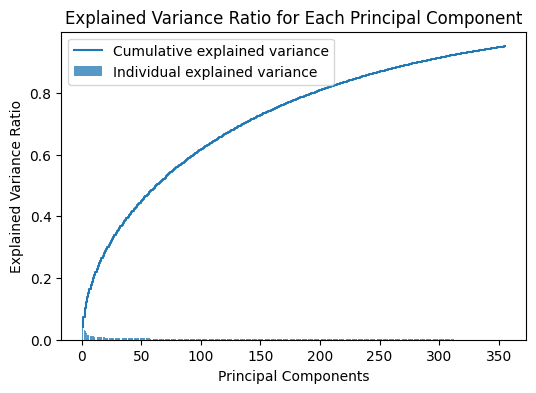

Selected Number of Components: 355
Current Method: linear_probe
Current Method: svm
Current Method: lda
Dimension Reduction Technique: autoencoding
Epoch 1/15
320/320 [==============================] - 3s 7ms/step - loss: 0.9121 - val_loss: 0.8307
Epoch 2/15
320/320 [==============================] - 2s 6ms/step - loss: 0.7838 - val_loss: 0.7693
Epoch 3/15
320/320 [==============================] - 2s 6ms/step - loss: 0.7358 - val_loss: 0.7415
Epoch 4/15
320/320 [==============================] - 2s 6ms/step - loss: 0.7102 - val_loss: 0.7265
Epoch 5/15
320/320 [==============================] - 2s 6ms/step - loss: 0.6940 - val_loss: 0.7160
Epoch 6/15
320/320 [==============================] - 2s 6ms/step - loss: 0.6826 - val_loss: 0.7084
Epoch 7/15
320/320 [==============================] - 2s 7ms/step - loss: 0.6739 - val_loss: 0.7032
Epoch 8/15
320/320 [==============================] - 2s 7ms/step - loss: 0.6673 - val_loss: 0.6989
Epoch 9/15
320/320 [==============================] 

In [61]:
if run_type == 'test':
    # Choose Autoencoder Dimensions/ Min Variance Required for PCA
    encoding_dim = 256
    epoch_count = 15
    desired_variance_threshold = 0.95

    # Run the classification solver
    accuracy_table, statistics = runner(feature_maps_train, feature_labels_train, feature_maps_test, feature_labels_test, classification_methods=classification_methods,dim_red_methods=dim_red_methods, verbose=True, encoding_dim = encoding_dim, epoch_count=epoch_count, desired_variance_threshold=desired_variance_threshold, dimension_limiter=len(feature_labels_test))

    # Create the Accuracy Dataframe
    overall_table = accuracy_table[0]
    for i in range(1, len(accuracy_table)):
        overall_table = pd.concat([overall_table, accuracy_table[i]])
    overall_table=overall_table.sort_values(by=['test_accuracy', 'train_accuracy'], ascending=False)

    # overall_table.to_csv(save_file_name)

    print(overall_table)